In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gzip

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import glob
from time import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
sns.set()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)
# tf.get_logger().setLevel('INFO')


Num GPUs Available:  1


In [3]:
train_labels_df = pd.read_csv('/kaggle/input/arabic-hwr-ai-pro-intake1/train.csv')
test_labels_df = pd.read_csv('/kaggle/input/arabic-hwr-ai-pro-intake1/test.csv')

In [4]:
train_labels_df.head()

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19


In [5]:
train_labels_df.dtypes

id       int64
label    int64
dtype: object

In [6]:
test_labels_df.head()

,id
0,0
1,1
2,2
3,3
4,4


In [7]:
train_labels_df['label'].value_counts()

24    480
2     480
22    480
20    480
3     480
6     480
7     480
5     480
9     480
1     480
25    480
12    480
4     480
26    480
16    480
8     480
15    480
13    480
11    480
21    480
18    480
28    480
23    480
10    480
19    480
14    480
17    480
27    480
Name: label, dtype: int64

In [8]:
train_labels_df['label'].value_counts().count()

28

In [9]:
from PIL import Image
def load_images(path):
    pathes_list = np.sort(glob.glob(path))
    features = np.empty((len(pathes_list), 32, 32), dtype=np.float32)
    for index, file_path in enumerate(pathes_list):
        features[index] = Image.open(file_path).convert('L')
    return features

In [10]:
train_features = load_images('/kaggle/input/arabic-hwr-ai-pro-intake1/train/*')
test_features = load_images('/kaggle/input/arabic-hwr-ai-pro-intake1/test/*')

In [11]:
print(train_features.shape)
print(test_features.shape)

(13440, 32, 32)
(3360, 32, 32)


In [12]:
def display_image(images, labels, pos):
    image = images[pos].squeeze()
    plt.title('Example %d. Label: %d' % (pos, labels[pos]))
    plt.imshow(image, cmap=plt.cm.gray_r)

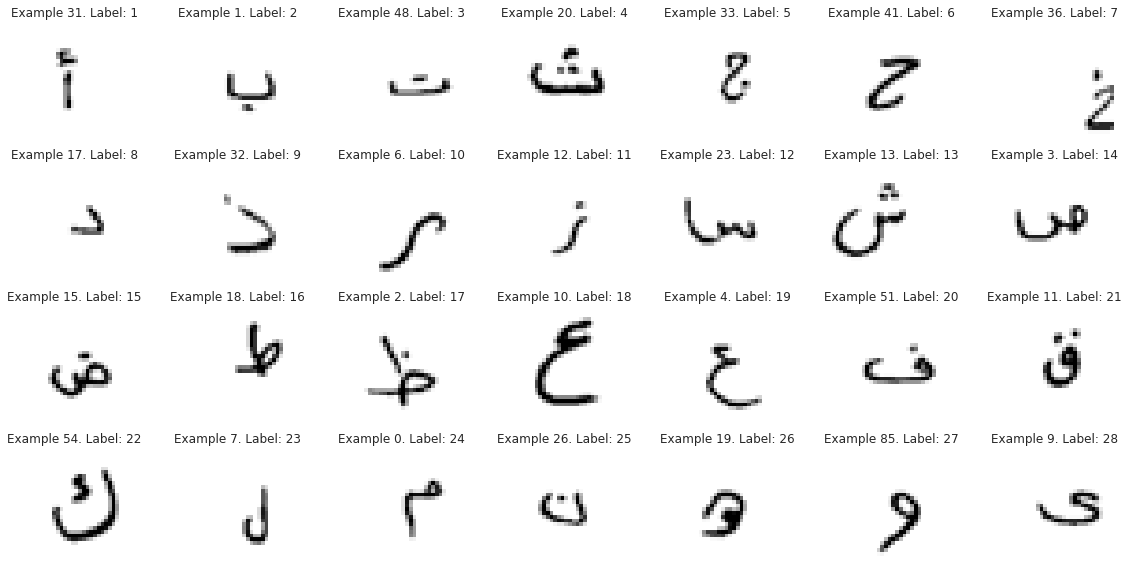

In [13]:
fig, ax = plt.subplots(4, 7, figsize=(20, 10))
index_list = train_labels_df.groupby('label').first()['id'].tolist()
i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        display_image(train_features, train_labels_df['label'], index_list[i])
        plt.axis('off')
        i+=1

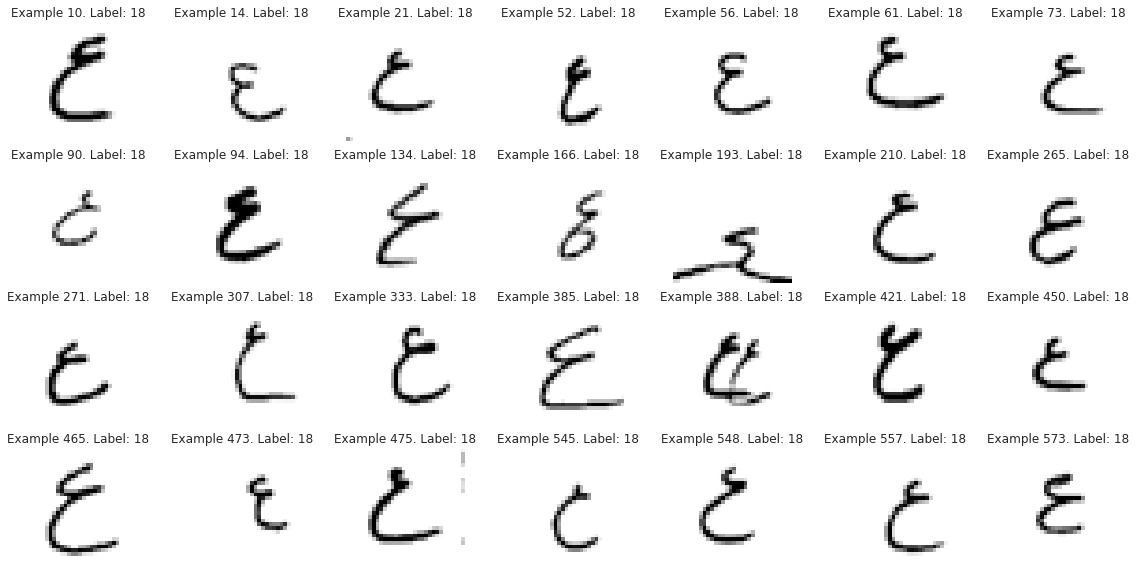

In [14]:
fig, ax = plt.subplots(4, 7, figsize=(20, 10))
index_list = train_labels_df[train_labels_df['label']==18].iloc[:28, :]['id'].tolist()
i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        display_image(train_features, train_labels_df['label'], index_list[i])
        plt.axis('off')
        i+=1

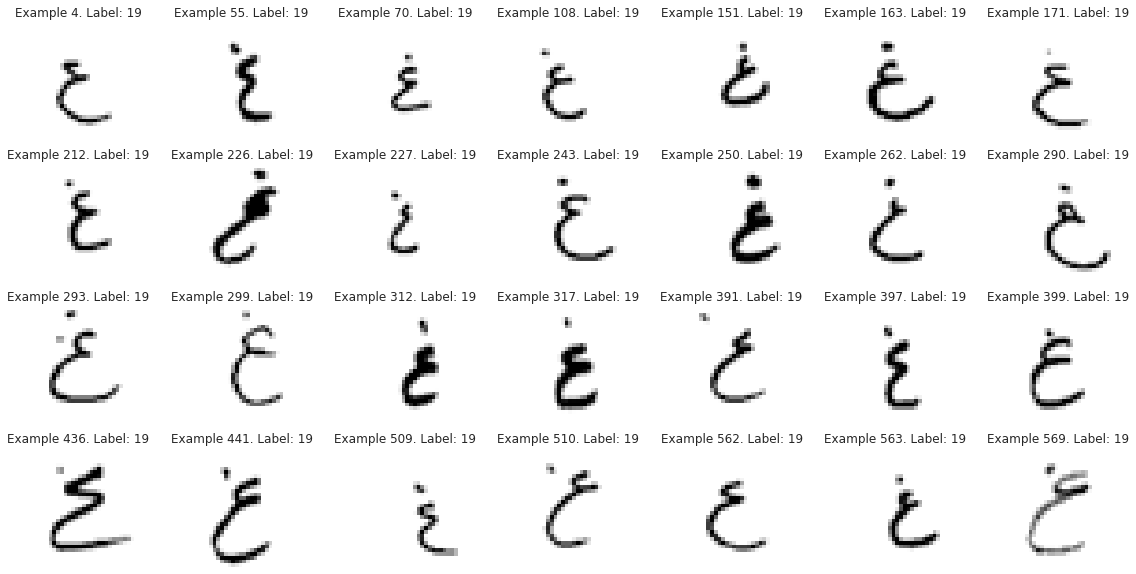

In [15]:
fig, ax = plt.subplots(4, 7, figsize=(20, 10))
index_list = train_labels_df[train_labels_df['label']==19].iloc[:28, :]['id'].tolist()
i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        display_image(train_features, train_labels_df['label'], index_list[i])
        plt.axis('off')
        i+=1

In [16]:
train = {}
test = {}
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train_features, train_labels_df['label'], test_size=0.1, stratify=train_labels_df['label'],random_state=0)

In [17]:
print('# of training images:', train['features'].shape)
print('# of validation images:', validation['features'].shape)
print('# of training labels:', train['labels'].shape)
print('# of validation labels:', validation['labels'].shape)

# of training images: (12096, 32, 32)
# of validation images: (1344, 32, 32)
# of training labels: (12096,)
# of validation labels: (1344,)


In [18]:
train['labels']

12741    25
11942    16
12045     1
5126     28
6027      9
         ..
5325      3
2607     16
9240     13
4256     17
3412      5
Name: label, Length: 12096, dtype: int64

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',strides=1, activation='relu',input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
#     tf.keras.layers.GaussianNoise(5),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
#     tf.keras.layers.GaussianNoise(5),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
#     tf.keras.layers.GaussianNoise(5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=1024, activation='relu'),
#     BatchNormalization(),
#     tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(units=512, activation='relu'),
#     tf.keras.layers.Dense(units=128, activation='relu'),
#     BatchNormalization(),
#     tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(units=29, activation='softmax')
])

In [46]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)            

In [47]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

EPOCHS = 200
BATCH_SIZE = 512
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [48]:
data_rotation = tf.keras.Sequential([
  layers.RandomRotation(10),
])

data_rotation_rev = tf.keras.Sequential([
  layers.GaussianNoise(5),
])

data_width_shift = tf.keras.Sequential([
  tf.keras.layers.RandomTranslation(height_factor=(0, 0), width_factor=(-0.09, 0.09)),
])

data_height_shift = tf.keras.Sequential([
  tf.keras.layers.RandomTranslation(height_factor=(-0.09, 0.09), width_factor=(0, 0)),
])


X_train, y_train = train['features']/255, to_categorical(train['labels'])
X_validation, y_validation = validation['features']/255, to_categorical(validation['labels'])

X_train1 = data_rotation(X_train)
X_train2 = data_width_shift(X_train)
X_train3 = data_height_shift(X_train)
X_train4 = data_rotation_rev(X_train)

X_train_aug_data = np.concatenate((X_train, X_train1, X_train2, X_train3, X_train4), axis=0)
y_train_aug_data = np.concatenate((y_train, y_train, y_train, y_train, y_train), axis=0)

X_train_aug_data = np.expand_dims(X_train_aug_data, axis=-1) # <--- add batch axis
X_validation = np.expand_dims(X_validation, axis=-1) # <--- add batch axis


train_generator = ImageDataGenerator().flow(X_train_aug_data, y_train_aug_data, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [49]:
X_train_aug_data.shape

(60480, 32, 32, 1)

In [50]:
y_train_aug_data.shape

(60480, 29)

In [51]:
print('# of training images:', X_train_aug_data.shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train_aug_data.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

# train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# valid_data = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))


# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), 
#                     epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard])


history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[model_checkpoint_callback])

# of training images: 60480
# of validation images: 1344
Epoch 1/200
118/118 [==============================] - 3s 24ms/step - loss: 2.7595 - accuracy: 0.1873 - val_loss: 1.0483 - val_accuracy: 0.6455

Epoch 00001: val_accuracy improved from -inf to 0.64551, saving model to tmp/checkpoint
Epoch 2/200
118/118 [==============================] - 3s 22ms/step - loss: 2.0104 - accuracy: 0.3958 - val_loss: 0.5222 - val_accuracy: 0.8242

Epoch 00002: val_accuracy improved from 0.64551 to 0.82422, saving model to tmp/checkpoint
Epoch 3/200
118/118 [==============================] - 3s 22ms/step - loss: 1.7882 - accuracy: 0.4724 - val_loss: 0.3501 - val_accuracy: 0.8818

Epoch 00003: val_accuracy improved from 0.82422 to 0.88184, saving model to tmp/checkpoint
Epoch 4/200
118/118 [==============================] - 3s 23ms/step - loss: 1.6917 - accuracy: 0.5025 - val_loss: 0.2760 - val_accuracy: 0.9160

Epoch 00004: val_accuracy improved from 0.88184 to 0.91602, saving model to tmp/checkpoint
Ep

In [52]:
model.load_weights(checkpoint_filepath)

In [53]:
# X_train.shape[0]//BATCH_SIZE
# validation_steps = X_validation
train_score = model.evaluate(X_train_aug_data, y_train_aug_data, verbose=0)
val_score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Train accuracy:', train_score[1]*100)
print('\n', 'Validation accuracy:', val_score[1]*100)
val_score


 Train accuracy: 68.30357313156128

 Validation accuracy: 98.66071343421936


[0.09549175947904587, 0.9866071343421936]

In [54]:
loss = {'loss':history.history['loss'], 'val_loss':history.history['val_loss']}
acc = {'accuracy':history.history['accuracy'], 'val_loss':history.history['val_accuracy']}

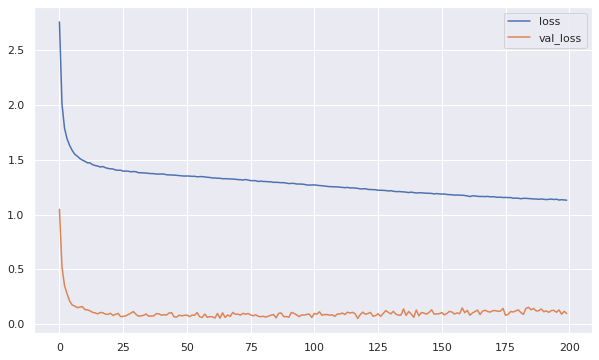

In [55]:
pd.DataFrame(loss).plot(figsize=(10, 6));

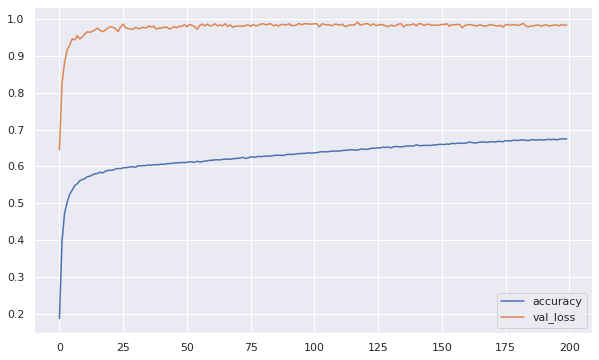

In [56]:
pd.DataFrame(acc).plot(figsize=(10, 6));

In [57]:
y_val_hat = np.argmax(model.predict(X_validation), axis=-1)

<AxesSubplot:>

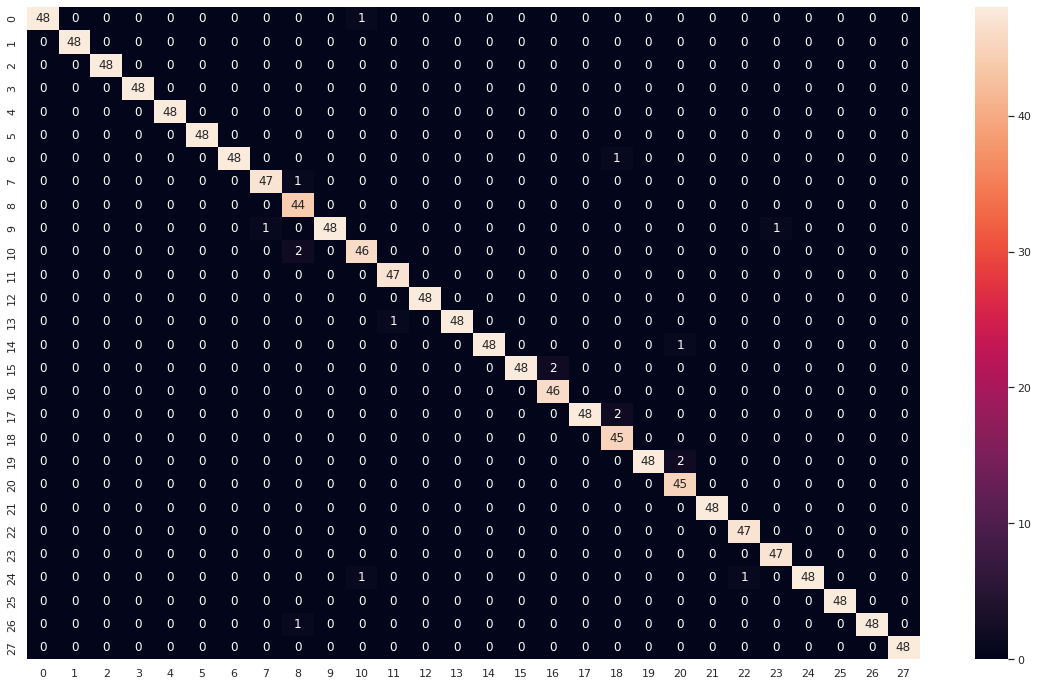

In [58]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_val_hat, np.argmax(y_validation, axis=-1))
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)

In [59]:
test_features_expand = np.expand_dims(test_features/255, axis=-1) # <--- add batch axis

In [60]:
y_hat = np.argmax(model.predict(test_features_expand), axis=-1)

In [61]:
test_labels_df['label'] = y_hat

In [62]:
# labels_dict = {1:'alf', 2:'baa', 3:'taa', 4:'t', 5:'gem', 6:'7aa', 7:'5aa', 8:'dal', 9:'zal', 10:'raa', 11:'zay', 12:'syn', 13:'sheen', 14:'sad', 15:'daad', 16:'taa', 17:'zaa', 18:'3yn', 19:'ghyn', 20:'faa', 21:'kk', 22:'kaf', 23:'lam', 24:'mym', 25:'noon', 26:'haa', 27:'waaw', 28:'yaa'}
# test_labels_df['map'] = test_labels_df['label'].map(labels_dict)

In [63]:
test_labels_df.to_csv('/kaggle/working/submission.csv', index=False)